In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

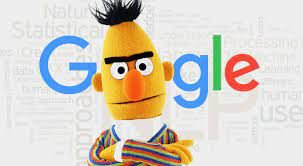

# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import re
import math
from bs4 import BeautifulSoup
import random

In [3]:
pip install bert-for-tf2

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

## As the data is in XML

In [6]:
cols=["sentiment","id","date","query",'user',"text"]
data=pd.read_csv("/kaggle/input/stanford-140-for-nlp/training.1600000.processed.noemoticon.csv",
                header=None,
                names=cols,
                engine="python",
                encoding="latin1")

In [7]:
# Dropping some use less columns
data.drop(["id","date",'query',"user"],axis=1,inplace=True)

In [8]:
data.head()

# Cleaning Data

In [9]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet,"lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+"," ",tweet) # like replace for string
    tweet = re.sub(r"https?://[A-Za-z0-9./]+",' ',tweet) # replacing https and ? as s is not conformed
    tweet = re.sub(r"[^a-zA-Z.!?']"," ",tweet) # removing everything other than these
    tweet = re.sub(r" +"," ",tweet)
    return tweet

In [10]:
%%time
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [11]:
data_clean[0]

In [12]:
# Changing the value of labels
data_labels=data.sentiment.values
data_labels[data_labels==4] = 1

# Tokenization
## we need to create a BERT layer to have access to meta data for tokenizer(like vocab size)

### using Small BERT

In [14]:
FullTokenizer=bert.bert_tokenization.FullTokenizer
# at hub all the pre-trained models are present
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", 
                          trainable=False)
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=FullTokenizer(vocab_file,do_lower_case)

### Here we can see how the tokenizer tokenizes the values

In [15]:
def encode_sent(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [16]:
%%time
data_inputs=[encode_sent(sent) for sent in data_clean]

# Data Creation
### We will create padded batches (so wee pad sentences for each batch independently), this way we add the minimum of padding tokens possible. For that, we sort sentences by length , apply padded_batches and then shuffle

In [21]:
import time 
while True:
    print("5")
    time.sleep(80)

In [22]:
data_with_len=[[sent, data_labels[i],len(sent)]
                for i ,sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
# As our data was sorted by labels to make batches of different sizes have all the data types
# Now sorting the data by length of the sentence
data_with_len.sort(key=lambda x: x[2])
sorted_all=[(sent_lab[0],sent_lab[1])
            for sent_lab in data_with_len if sent_lab[2] > 7]

## only using long sentences greater than 7 for better understanding of the sentencev by the model


In [23]:
## Creating a Tensordata set to be used by Tensorflow
## needed a Gerator to give to tensorflow so using list as it is also a generator
all_dataset=tf.data.Dataset.from_generator(lambda :sorted_all ,
                                          output_types=(tf.int32,tf.int32))

In [24]:
next(iter(all_dataset))

In [25]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None,),()))
## Padding the tensors to make it of equal size

In [26]:
next(iter(all_batched))

## Here we get batch of 32 sentences, and the corresponding labels

In [27]:
## The numbers of input we have/batch size = no of batches 
NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
## get 1/10 of it to create testing set
NB_BATCHES_TEST = NB_BATCHES//10
## Need to shuffle the data set as shaorter are in the start and longer at the end
all_batched.shuffle(NB_BATCHES)
## If size is large use less than No of batches in buffer

## Creating testing and training dataset

test_dataset=all_batched.take(NB_BATCHES_TEST)
train_dataset=all_batched.skip(NB_BATCHES_TEST)

# Model Building

In [28]:
## nb_filters == no of filter
##CNN filters for ecah size 50 size 4 , 3 , 2

## FFN_units == No of hidden units used in dense layer in the end ..
## Between two dense layers the number of hideen layer 

## nb_classes : no of classes for classification : 2 by default in this case


In [56]:
class DCNN(tf.keras.Model):
    
    def __init__(self,vocab_size, emb_dim=128, nb_filters=50, FFN_units=512,
                    nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):
        
        ## inherits from class its comming from, which allows us use the methods from the class which we are inheriting from
        
        super(DCNN,self).__init__(name=name)
        ## Creating the embedding layer
        ## creating vectors
        
        self.embedding = layers.Embedding(vocab_size,emb_dim)
        
        # creating the CNN layer
        ## using padding valid : stride out feature detecture by 1
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        
        ## Creating a layer which takes the max of all the outputs
        
        self.pool=layers.GlobalAveragePooling1D()
        
        ## Creatign two dense layers with hidden number of units between the two dense layers
        
        self.dense1=layers.Dense(units=FFN_units,
                                 activation="relu")
        ## Create a sense of gerenalarity using Dropout
        
        self.dropout=layers.Dropout(dropout_rate)
        
        if nb_classes==2:
            
            self.dense2=layers.Dense(units=1,
                                     activation="sigmoid")
        else :
            self.dense2=layers.Dense(units=nb_classes,
                                     activation="softmax")
        
    
    def call(self,inputs,training):
        ## training Bool:if trainign false not use of fropout
        x=self.embedding(inputs)
        x_1=self.bigram(x)
        x_1=self.pool(x_1)
        ## each of 50 feature detector of size 2 we get 1 number which has max values
        
        x_2=self.trigram(x)
        x_2=self.pool(x_2)
        
        x_3=self.fourgram(x)
        x_3=self.pool(x_3)   ## (batch_szie, nb_filters)
        
        ## now concat all the results and apply dense layers
        
        merged=tf.concat([x_1,x_2,x_3],axis=1) ## (batch_size,3*nb_flters)
        merged=self.dense1(merged)
        
        merged=self.dropout(merged,training)
        output=self.dense2(merged)
        
        return output
        
        

## Training our model

In [57]:
VOCAB_SIZE=len(tokenizer.vocab)
EMB_DIM=200
NB_FILTERS=100
FFN_UNITS=256
NB_CLASSES=2

DROPOUT_RATE=0.2

NB_EPOCHS=5

In [58]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [59]:
if NB_CLASSES==2:
    Dcnn.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["sparse_categorcal_accuracy"])

In [60]:
## Creating Checkpoint in order to save the model weights of model
checkpoint_path="./ckpt_bert_tok"

ckpt=tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager=tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=1)

if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Latest chekcpoint restored")

## Creating Callbacks

In [61]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_ends(self,epoch,logs="None"):
        ckpt_manager.save()
        print(f"Checkpoint is saved at {checkpoint_path}")

In [62]:
Dcnn.fit(train_dataset,
        epochs=NB_EPOCHS,
        callbacks=[MyCustomCallback()])

# Evaluating the model

In [63]:
results=Dcnn.evaluate(test_dataset)
print(results)

> #### As we are using BERT is trained on a bigger corpus of words, so it gives better acccuracy, if we train it on out own model, as out courspus is not very large the data might not get as good accuracy as we are getting when using BERT

In [66]:
def get_prediction(sent):
    tokens = encode_sent(sent)
    ## As tensorflow works with batches need to send batches even if we have only 1 senteance
    inputs = tf.expand_dims(tokens,0)
    output = Dcnn(inputs,training=False)
    ## *2 as we have two classes 
    sentiment = math.floor(output*2)
    
    if sentiment ==0:
        print(f"Output of the model : {sentiment}\npredicted sentiment : negative")
    elif sentiment ==1:
        print(f"Output of the model : {sentiment}\npredicted sentiment : positive")

In [75]:
get_prediction("Pls help me, i am stuck")